In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

Dataset collected from:
    
    https://www.kaggle.com/datafiniti/palm-springs-vacation-rentals

In [2]:
df = pd.read_csv("./input/palm_springs_vacation_rentals.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11374 entries, 0 to 11373
Data columns (total 26 columns):
city                     11374 non-null object
country                  11370 non-null object
dateAdded                11374 non-null object
dateUpdated              11374 non-null object
deposit                  285 non-null object
descriptions             10377 non-null object
features                 8581 non-null object
fees                     6719 non-null object
languages                8 non-null object
lat                      11337 non-null float64
long                     11337 non-null float64
name                     11372 non-null object
numBathroom              11365 non-null object
numBedroom               11374 non-null int64
numBed                   1647 non-null float64
numPeople                11374 non-null object
people                   7412 non-null object
petPolicy                18 non-null object
prices.dateSeen          10621 non-null object
prices.da

We are going to predict data for Palm Springs, so all observations will be recorder for United States; Additionally, it looks like `"province"` holds only one value:

In [4]:
df["province"].unique()

array(['CA'], dtype=object)

Let's drop these columns as they will not bring any additional information:

In [5]:
df.drop(["country", "province"], axis=1, inplace=True)

## Assessing the data about the price

### 1. Let's revisit rows with missing target value

In [6]:
df[ df["prices.price"].isnull() ].head()

,city,dateAdded,dateUpdated,deposit,descriptions,features,fees,languages,lat,long,...,numPeople,people,petPolicy,prices.dateSeen,prices.dateValidEnd,prices.dateValidStart,prices.minStay,prices.period,prices.price,rules
311,Palm Springs,2015-10-25T18:51:37Z,2016-04-04T00:44:30Z,USD 149.00,"[""Spectacular mountain view from the casita, t...","[{""key"":""Smoking Allowed"",""value"":""yes""},{""key...","[""USD 29.00"",""USD 49 / night after 2 guests""]",NaN,33.832151,-116.527093,...,4,"[{""name"":""Thibault (tebow)"",""title"":""Host""}]",Pets Allowed,NaN,NaN,NaN,NaN,NaN,NaN,Please read carefully - by submitting an inqui...
822,Palm Springs,2015-10-23T05:30:52Z,2016-03-11T09:46:06Z,NaN,"Located in desirable 'Movie Colony East', near...",NaN,NaN,NaN,33.839350,-116.529305,...,6,"[{""dateSeen"":""2015-10-17T00:00:00Z"",""name"":""Ab...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1251,Downtown Palm Springs Vacation Rentals,2016-03-11T09:45:44Z,2016-03-11T09:45:44Z,NaN,La Casa Del Sol (The House of Sun) in Rancho M...,NaN,NaN,NaN,33.760593,-116.418040,...,8,"[{""dateSeen"":""2016-03-10T00:00:00Z"",""name"":""Mc...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963,Palm Springs,2016-01-21T19:43:54Z,2016-01-27T01:07:00Z,NaN,Original description written in a non-supporte...,NaN,NaN,NaN,33.846680,-116.552925,...,8,"[{""dateSeen"":""2016-01-20T00:00:00Z"",""name"":""We...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2302,Palm Springs,2015-10-28T18:51:00Z,2016-03-03T18:57:21Z,NaN,NaN,"[{""key"":""Guest Access"",""value"":""Entire home/ap...",NaN,NaN,33.844601,-116.541801,...,12,"[{""name"":""Jeffery"",""title"":""Host""}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,No smoking. Anyone that is found to have smoke...


These have also many other missing values and it will be difficult to fill them in. At that point - let's try to do the simplet thing to help us get up and running and remove those rows completely:

In [7]:
df = df[ ~df["prices.price"].isnull() ]

### 2. Parsing the price

Price is kept as a text value in format of `"USD 9999"` - let's parse it to proper numerical value:

In [8]:
import re

def parse_number(price_string, number_parser=float):
    try:
        return number_parser(re.search("[\d\.]+", price_string).group(0))
    except:
        print("Error for: {}".format(price_string))

In [9]:
df["price"] = df["prices.price"].map(lambda x: parse_number(x, number_parser=float))

Let's review the updated column:

In [10]:
df["price"].head()

0    3300.0
1    3200.0
2     525.0
3     500.0
4    2499.0
Name: price, dtype: float64

In [11]:
df["price"].describe()

count    10621.000000
mean      2581.396667
std       4763.887324
min         44.000000
25%        425.000000
50%       1195.000000
75%       2954.000000
max      99820.000000
Name: price, dtype: float64

At that point we have valida data in the `"price"` column - let's move on to assessing the features.

## Assessing the data about bathrooms

In [12]:
df["numBathroom"].unique()

array(['2', '3', '4', '6', '1', '9', '5', '12', '1.5', '2.5', '3.5',
       '4.5', nan, '5.5', '8+', '6.5', '7', '8', '10', '13'], dtype=object)

### Missing values

There are some observations that have no bathrooms specifed - let's check them:

In [13]:
df[ df["numBathroom"].isnull() ]["numBed"]

2666    3.0
2794    1.0
2795    1.0
Name: numBed, dtype: float64

It's only `3` entries, and these look quite small places! Assuming the minimum amount bathrooms stoerd in dataset is `"1"` - we will use it to fill the empty values in this case.

In [14]:
df["numBathroom"].fillna("1", inplace=True)
df["numBathroom"].unique()

array(['2', '3', '4', '6', '1', '9', '5', '12', '1.5', '2.5', '3.5',
       '4.5', '5.5', '8+', '6.5', '7', '8', '10', '13'], dtype=object)

### non-decimal-parsable observations

There is one more outstanding case with strange value - `"8+"`. Let's examine it next:

In [15]:
df[ df["numBathroom"] == "8+" ]

,city,dateAdded,dateUpdated,deposit,descriptions,features,fees,languages,lat,long,...,people,petPolicy,prices.dateSeen,prices.dateValidEnd,prices.dateValidStart,prices.minStay,prices.period,prices.price,rules,price
3248,Palm Springs,2015-10-13T19:33:24Z,2015-11-06T20:13:55Z,NaN,NaN,"[{""key"":""Kitchen"",""value"":""Space where guests ...","[""USD 300.00""]",NaN,33.822399,-116.552586,...,"[{""name"":""Mclean Company"",""title"":""Host""}]",NaN,2015-07-30T00:00:00Z,NaN,NaN,NaN,Weekly,USD 8885.00,This property is professionally managed by McL...,8885.0


We could treat such a value either as `"8"` or `"8.5"`. Because this is only one example, it won't have signifficant impact for analysis if we take it "wrong", so for simplycity, we will re-use earlier defined `parse_number` and let it be treated as `"8"`:

In [16]:
df["numBathroom"] = df["numBathroom"].map(lambda x: parse_number(x, number_parser=float))
df["numBathroom"].unique()

array([ 2. ,  3. ,  4. ,  6. ,  1. ,  9. ,  5. , 12. ,  1.5,  2.5,  3.5,
        4.5,  5.5,  8. ,  6.5,  7. , 10. , 13. ])

## Assessing numPeople

In [17]:
df["numPeople"].unique()

array(['6', '8', '7', '10', '4', '2', '5', '3', '12', '11', '20', '9',
       '14', '1', '16', '16+', '13', '18', '15'], dtype=object)

There are no empty values, but there is interesting value that's not "just a number", the `"16+"` - let's check this observation to decide how to treat it:

In [18]:
df[ df["numPeople"] == "16+" ]

,city,dateAdded,dateUpdated,deposit,descriptions,features,fees,languages,lat,long,...,people,petPolicy,prices.dateSeen,prices.dateValidEnd,prices.dateValidStart,prices.minStay,prices.period,prices.price,rules,price
3248,Palm Springs,2015-10-13T19:33:24Z,2015-11-06T20:13:55Z,NaN,NaN,"[{""key"":""Kitchen"",""value"":""Space where guests ...","[""USD 300.00""]",NaN,33.822399,-116.552586,...,"[{""name"":""Mclean Company"",""title"":""Host""}]",NaN,2015-07-30T00:00:00Z,NaN,NaN,NaN,Weekly,USD 8885.00,This property is professionally managed by McL...,8885.0


In [19]:
df["numPeople"] = df["numPeople"].map(lambda x: parse_number(x, number_parser=int))
df["numPeople"].unique()

array([ 6,  8,  7, 10,  4,  2,  5,  3, 12, 11, 20,  9, 14,  1, 16, 13, 18,
       15])

In [22]:
df["deposit"].fillna("USD 0", inplace=True)
df["deposit"] = df["deposit"].map(lambda x: parse_number(x, number_parser=float))
df["deposit"].unique()

array([   0.,  750.,  100.,  300., 1000.,  400.,  500.,  800., 1500.,
        150.,  250.,  350.,  125.,  200.,   95., 3000.,  600.,  499.,
        299.,  375.,  850.,  225.,  450.,  700.])

In [26]:
df["deposit"].unique()

array([   0.,  750.,  100.,  300., 1000.,  400.,  500.,  800., 1500.,
        150.,  250.,  350.,  125.,  200.,   95., 3000.,  600.,  499.,
        299.,  375.,  850.,  225.,  450.,  700.])

## Review the cleaned data

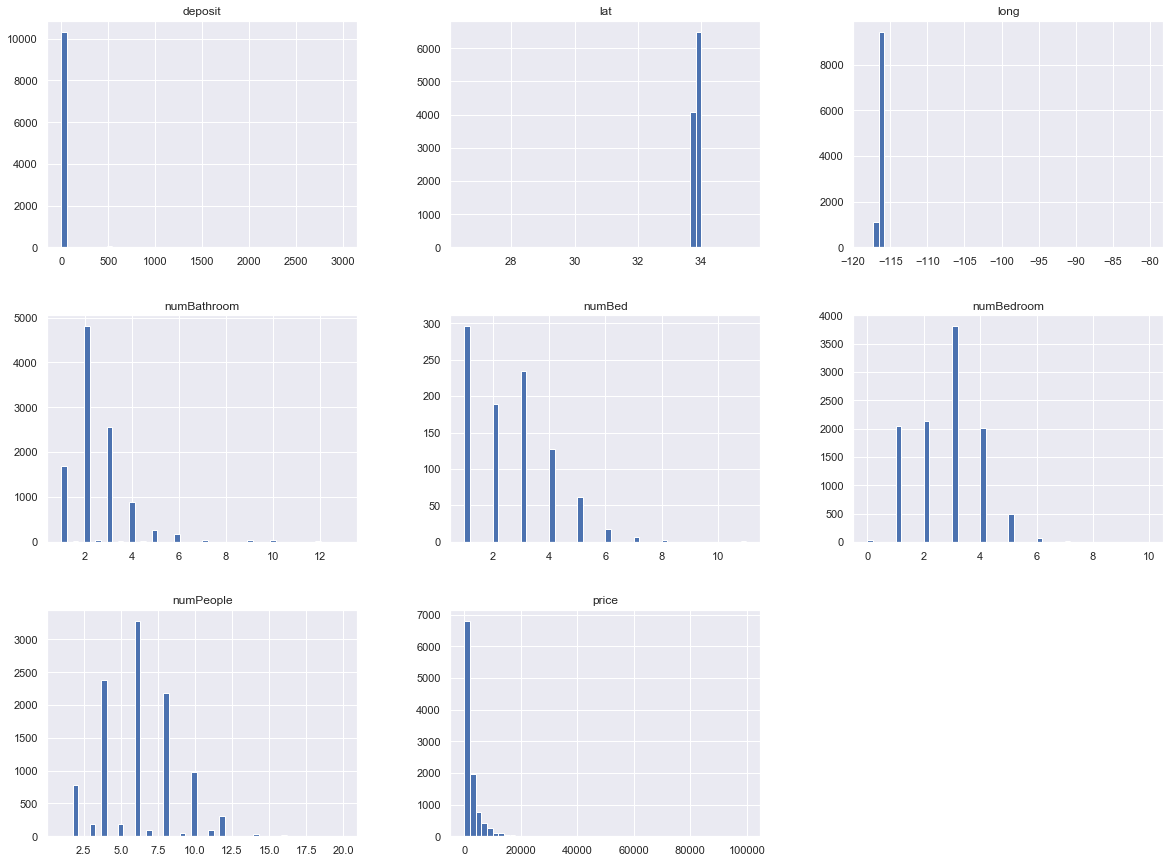

In [31]:
df.hist(bins=50, figsize=(20, 15));

### Correlation

In [30]:
df.corr()["price"].sort_values(ascending=False)

price          1.000000
numBed         0.447529
numBathroom    0.301408
numBedroom     0.284166
numPeople      0.241956
lat            0.013983
long          -0.017332
deposit       -0.052948
Name: price, dtype: float64

After excercise of cleaning the data, we can see how some of the features corelate to the `"price"` that's going to be predicted. At that point, we will use `"numBed"`, `"numBathroom"`, `"numBedroom"` and `"numPeople"` numerical features, that show correlation and we will disregard the rest (even `"deposit"`) as they don't appear to be much correlated.

Additonally, `"city"` and `"prices.period"` could be strong indicators and these will also be taken into the account.

## Creating Train and Test Sets

In [44]:
from sklearn.model_selection import train_test_split

features_to_select = [
    "price",
    "numBed",
    "numBathroom",
    "numBedroom",
    "numPeople",
    "city",
    "prices.period",
]

train_set, test_set = train_test_split(
    df[ features_to_select ],
    random_state=42
)

In [45]:
train_set.head()

,price,numBed,numBathroom,numBedroom,numPeople,city,prices.period
4989,350.0,NaN,1.0,1,2,Palm Springs,Weekly
5609,935.0,NaN,2.0,1,3,Downtown Palm Springs Vacation Rentals,Weekly
8695,530.0,NaN,3.0,4,8,Palm Springs,Weekend night
7421,685.0,NaN,4.0,4,8,Palm Springs,Weekend night
10094,260.0,NaN,4.0,4,10,Palm Springs,Weekend night


In [51]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7965 entries, 4989 to 8011
Data columns (total 7 columns):
price            7965 non-null float64
numBed           705 non-null float64
numBathroom      7965 non-null float64
numBedroom       7965 non-null int64
numPeople        7965 non-null int64
city             7965 non-null object
prices.period    7744 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 497.8+ KB


### Visualise the correlation

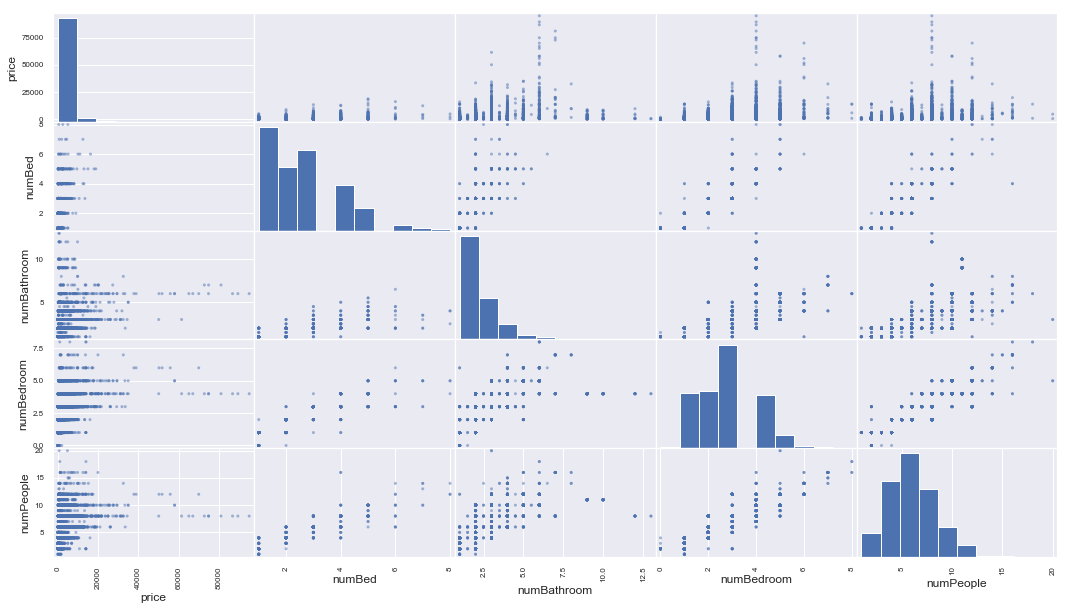

In [58]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_set, figsize=(18, 10));

## Assessing Periods

There are observations that don't have periods specified. Let's take closer look at them - would that be possible to guess what "proper periods" should have been set?

In [68]:
train_set["prices.period"].unique()

array(['Weekly', 'Weekend night', nan, 'Monthly', 'Weeknight', 'Nightly',
       'Weekend night, Weeknight'], dtype=object)

In [69]:
train_set[ train_set["prices.period"].isnull() ].head()

,price,numBed,numBathroom,numBedroom,numPeople,city,prices.period
2340,115.0,1.0,1.0,1,2,Palm Springs,NaN
2367,44.0,1.0,1.0,1,3,Palm Springs,NaN
2371,449.0,5.0,3.5,4,10,Palm Springs,NaN
2459,125.0,2.0,2.0,2,4,Palm Springs,NaN
2308,350.0,3.0,3.0,3,6,Palm Springs,NaN


In [66]:
train_set.groupby(["prices.period"])["price"].agg(['count', 'min', 'max']).sort_values(by=["min"])

,count,min,max
prices.period,,,
Nightly,67,49.0,720.0
Weekend night,2236,50.0,7995.0
Weeknight,820,50.0,2700.0
"Weekend night, Weeknight",7,119.0,750.0
Weekly,2969,250.0,34965.0
Monthly,1645,750.0,95060.0


Unfortunately, for the prices for currently specified periods do overlap and it won't be easy to distinguis if the observation's price indicates specific period it was meant to be set for. For non-specified periods, we will categorise them as `"Other"`, but this could be an opportunity to spend some more time investigating if we could assign proper periods to improve model's performance.

Additionally, there are observations with `"Weekend night, Weeknight"` which sounds very similar to `"Nightly"`.

Let's implement simple transformer we will be able to use in pipeline to handle these values for us:

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

class PricePeriodCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()

        X_copy["prices.period"] = X_copy["prices.period"].replace({"Weekend night, Weeknight": "Nightly"})\
                                                         .fillna("Other")
        
        return X_copy

cleaner = PricePeriodCleaner()
train_set_cleaned = cleaner.transform(train_set)

In [76]:
train_set_cleaned["prices.period"].unique()

array(['Weekly', 'Weekend night', 'Other', 'Monthly', 'Weeknight',
       'Nightly'], dtype=object)

## Extract features and target variable

In [77]:
X = train_set.drop("price", axis=1)
y = train_set["price"].copy()

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7965 entries, 4989 to 8011
Data columns (total 6 columns):
numBed           705 non-null float64
numBathroom      7965 non-null float64
numBedroom       7965 non-null int64
numPeople        7965 non-null int64
city             7965 non-null object
prices.period    7744 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 435.6+ KB


## Assessing numBeds

There are observations without `"numBeds"` specified - it seems logical that there are "at most" one bed per bedroom, so let's implement a transformer that will copy the `"numBedrooms"` into `"numBeds"` if not provided:

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

class NumBedImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_copy = X.copy()

        X_copy["numBed"] = X_copy["numBed"].fillna(X_copy["numBedroom"])
        
        return X_copy

num_bed_imputer = NumBedImputer()
train_set_imputed = num_bed_imputer.transform(train_set)
train_set_imputed.head()

,price,numBed,numBathroom,numBedroom,numPeople,city,prices.period
4989,350.0,1.0,1.0,1,2,Palm Springs,Weekly
5609,935.0,1.0,2.0,1,3,Downtown Palm Springs Vacation Rentals,Weekly
8695,530.0,4.0,3.0,4,8,Palm Springs,Weekend night
7421,685.0,4.0,4.0,4,8,Palm Springs,Weekend night
10094,260.0,4.0,4.0,4,10,Palm Springs,Weekend night


Let's combine the transformes into pipeline to perform whole cleanup automatically.

**It is important** - this kind of transformation will be only applicable to `train`/`test` sets to prepare for training the model, but we will assume the data **always** passed from the application, hence we will not attempt to _productionise_ this this pipeline. 

In [103]:
from sklearn.pipeline import Pipeline

cleaner_pipeline = Pipeline([
    ("num_bed_imputer", NumBedImputer()),
    ("price_period_cleaner", PricePeriodCleaner())
])

X_cleaned = cleaner_pipeline.fit_transform(X)

Let's revisit data cleaned by the pipeline:

In [104]:
X_cleaned.head()

,numBed,numBathroom,numBedroom,numPeople,city,prices.period
4989,1.0,1.0,1,2,Palm Springs,Weekly
5609,1.0,2.0,1,3,Downtown Palm Springs Vacation Rentals,Weekly
8695,4.0,3.0,4,8,Palm Springs,Weekend night
7421,4.0,4.0,4,8,Palm Springs,Weekend night
10094,4.0,4.0,4,10,Palm Springs,Weekend night


In [105]:
X_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7965 entries, 4989 to 8011
Data columns (total 6 columns):
numBed           7965 non-null float64
numBathroom      7965 non-null float64
numBedroom       7965 non-null int64
numPeople        7965 non-null int64
city             7965 non-null object
prices.period    7965 non-null object
dtypes: float64(2), int64(2), object(2)
memory usage: 435.6+ KB


There are no empty values anymore! We will be able to use this pipeline to clean `test_set` soon...

Next, our data set has categorical values (`"city"` and `"prices.period"`) and they have to by turned intu numerical values. There is a couple of ways this could be acheived - either "Labeling", or "One Hot Encoding" and we will use the latter one.

For better reusability to apply the same transformation in future - we encode them in another pipeline:

In [106]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

features_to_keep = [
    "numBed",
    "numBathroom",
    "numBedroom",
    "numPeople",
]

preparation_pipeline = ColumnTransformer([
    ("to_keep", "passthrough", features_to_keep),
    ("city_cat", OneHotEncoder(dtype=np.int8), ["city"]),
    ("period_cat", OneHotEncoder(dtype=np.int8), ["prices.period"]),
])

X_prepared = preparation_pipeline.fit_transform(X_cleaned)
X_prepared[0]

array([1., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.])

## Model Selection

### Prepare test set for model evaluation

Let's use our pipelines we defined to preprocess test set:

In [112]:
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"]

In [113]:
X_test_clean = cleaner_pipeline.transform(X_test)
X_test_prepared = preparation_pipeline.transform(X_test_clean)
X_test_prepared.shape

(2656, 15)

### Choosing the Model

#### `LinearRegression`

In [117]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [118]:
lin_reg.score(X_test_prepared, y_test)

0.35238347735337716

Accuracy is quite low, around `35%`, but what does it mean for predicitons? Let's write simple function, where we subtract predicted values from actual ones, and see the difference:

In [148]:
def comparison(predicted, actual):
    data = np.array([predicted, actual, actual - predicted]).T
    return pd.DataFrame(data, columns=["Predicted", "Actual", "Difference"])

In [173]:
lin_reg_predictions = lin_reg.predict(X_test_prepared)
lin_reg_diffs = comparison(lin_reg_predictions, y_test)
lin_reg_diffs.head()

,Predicted,Actual,Difference
0,5943.148162,6240.0,296.851838
1,225.705964,525.0,299.294036
2,-316.760316,250.0,566.760316
3,2354.135519,400.0,-1954.135519
4,-2114.351231,230.0,2344.351231


We can see, for the first observation the model is off by `296.85` on the level of actual price being `6240.00` and predicted `5943.14`. That's actually not that bad.

Second observation though, is off by `299.29`, but considering values - actual `525.00` and predicted `225.70` means we're off by more than the half of the price.

Finally, third prediction is off by `566.76`, but predicted value value is negative (`-316.76`).

Regardless of the levels of accuracy, the fact that the model predicts negative prices disqualifies this model for using in production for predicting the prices.

#### `DecisionTreeRegressor`

In [174]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(random_state=42)
tree.fit(X_prepared, y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [175]:
tree.score(X_test_prepared, y_test)

0.7851424261042834

Decision tree was able to achieve accuracy of `78.51%`. Let's see how the predictions look like:

In [176]:
tree_predictions = tree.predict(X_test_prepared)

In [177]:
tree_diffs = comparison(tree_predictions, y_test)
tree_diffs.head()

,Predicted,Actual,Difference
0,4745.068493,6240.0,1494.931507
1,389.595041,525.0,135.404959
2,250.000000,250.0,0.000000
3,352.500000,400.0,47.500000
4,176.948980,230.0,53.051020


This model's predictions look much more promissing.

First prediction is off by `1494.93`, which is a big value for the higher values, but the second prediction is off by `135.40` and the third is exact value.

Finally - there are no negative values predicted in this sample of data. Let's take closer look at the predicted set as a whole then:

In [178]:
tree_diffs.describe()

,Predicted,Actual,Difference
count,2656.000000,2656.000000,2656.000000
mean,2593.763240,2571.297440,-22.465800
std,4448.091695,4945.585221,2292.303723
min,54.000000,45.000000,-21653.333333
25%,487.139785,416.500000,-439.642857
50%,1299.896414,1150.000000,-73.561169
75%,3667.053191,2927.000000,145.960000
max,79725.333333,99820.000000,49694.218045


Here we can see the mean prediction is `2590.76` while the mean of actual values is `2571.29` and the mean difference is `-22.46`, which means the model _overestimates_ the prices by `22.46` on this data set .

Let's review the two predictions, for which the difference is the bigest:

In [179]:
tree_diffs[ tree_diffs["Difference"] < -21653 ]

,Predicted,Actual,Difference
1853,76253.333333,54600.0,-21653.333333


In this case model overestimated the value by `21653.33` while the actual value was `54600.00`

In [180]:
tree_diffs[ tree_diffs["Difference"] > 49694 ]

,Predicted,Actual,Difference
1617,11565.781955,61260.0,49694.218045


In this instance the price was underestimated by `49694.21` - predicted `11565.78` against `61260.00`.

Despite huge differences in the most expensive properties, the model does very good job estimating smaller prices in most of the cases.

Let's try other estimators.

#### `RandomForestRegressor`

In [182]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=10, random_state=42)
forest.fit(X_prepared, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [183]:
forest.score(X_test_prepared, y_test)

0.7830015932317294

What is a bit surpising, the random forest has lower accuracy than the decision tree, yet, this is a good score.

In [185]:
forest_predictions = forest.predict(X_test_prepared)

In [186]:
forest_diffs = comparison(forest_predictions, y_test)
forest_diffs.head()

,Predicted,Actual,Difference
0,4800.336116,6240.0,1439.663884
1,392.348608,525.0,132.651392
2,250.000000,250.0,0.000000
3,399.113043,400.0,0.886957
4,177.550454,230.0,52.449546


In [187]:
forest_diffs.describe()

,Predicted,Actual,Difference
count,2656.000000,2656.000000,2656.000000
mean,2617.446402,2571.297440,-46.148962
std,4511.107190,4945.585221,2303.343865
min,74.434399,45.000000,-23013.433333
25%,490.104258,416.500000,-469.802232
50%,1291.887826,1150.000000,-75.338693
75%,3656.435619,2927.000000,132.495466
max,78760.654242,99820.000000,49332.370286


### `Ridge`

In [189]:
from sklearn.linear_model import Ridge

ridge = Ridge(random_state=42)
ridge.fit(X_prepared, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=42, solver='auto', tol=0.001)

In [190]:
ridge.score(X_test_prepared, y_test)

0.35236942421392925

Ridge model also has very low score...

### Searching best paramters

From the models we've tried so far it's only `DecisionTree` and `RandomForest` that had highest scores, so we will try to find the best paramteres for both of them next:

In [191]:
from sklearn.model_selection import GridSearchCV

### Parameters for DecisionTree

In [212]:
tree_param_grid = [
    {'max_depth': [None, 3, 10, 30, 40, 50], 
     'min_samples_split': [2, 5, 10],
     'min_samples_leaf': [1, 2, 5, 10],
     'max_features': [None, "auto", "sqrt", "log2", 
                      2, 5, 10, 15]},
]

tree_reg = DecisionTreeRegressor()

tree_grid_search = GridSearchCV(tree_reg, tree_param_grid, cv=5,
                                scoring="neg_mean_squared_error",
                                return_train_score=True,
                                n_jobs=8, verbose=4)

tree_grid_search.fit(X_prepared, y)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1468 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 2880 out of 2880 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid=[{'max_depth': [None, 3, 10, 30, 40, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5, 10], 'max_features': [None, 'auto', 'sqrt', 'log2', 2, 5, 10, 15]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=4)

In [213]:
tree_grid_search.best_params_

{'max_depth': None,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [229]:
cvres = tree_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2342.6219535627633 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
2260.6521953952924 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
2357.6291893512685 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
2354.572496557998 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2}
2318.16160553651 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
2321.459980761652 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10}
2381.9769026658646 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
2374.595694813335 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 5}
2370.52628308397 {'max_depth': None, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10}
2882.021738357548 {'max_depth': 

#### Reviewing the scores

First, let's check if we managed to improve the prvious score (`78.51%`) achieved on the training set:

In [228]:
tree_grid_search.best_estimator_.score(X_prepared, y)

0.8004891053997341

There is an improvement achieved when tuning the parameters. Let's see how does the model behave on the test set with data it didn't see before:

In [214]:
tree_grid_search.best_estimator_.score(X_test_prepared, y_test)

0.7839934851003418

As expected, the score is lower than on the training data.

### Parameters for `RandomForest`

In [222]:
forest_param_grid = [
    {'n_estimators': [3, 10, 15, 20, 30, 40], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10, 15, 20, 30, 40], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()

forest_grid_search = GridSearchCV(forest_reg, forest_param_grid, cv=5,
                                  scoring="neg_mean_squared_error",
                                  return_train_score=True,
                                  n_jobs=8, verbose=4)

forest_grid_search.fit(X_prepared, y)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 210 out of 210 | elapsed:    2.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=8,
       param_grid=[{'n_estimators': [3, 10, 15, 20, 30, 40], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10, 15, 20, 30, 40], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=4)

In [223]:
forest_grid_search.best_params_

{'bootstrap': False, 'max_features': 4, 'n_estimators': 15}

In [226]:
cvres = forest_grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

2331.679272580871 {'max_features': 2, 'n_estimators': 3}
2285.649388215688 {'max_features': 2, 'n_estimators': 10}
2251.7826204456164 {'max_features': 2, 'n_estimators': 15}
2269.263702788501 {'max_features': 2, 'n_estimators': 20}
2267.320886111767 {'max_features': 2, 'n_estimators': 30}
2265.916271473506 {'max_features': 2, 'n_estimators': 40}
2375.9475230645808 {'max_features': 4, 'n_estimators': 3}
2250.4548398214106 {'max_features': 4, 'n_estimators': 10}
2272.6800195752016 {'max_features': 4, 'n_estimators': 15}
2245.047383560474 {'max_features': 4, 'n_estimators': 20}
2266.17404626818 {'max_features': 4, 'n_estimators': 30}
2267.199938802931 {'max_features': 4, 'n_estimators': 40}
2306.3007469266286 {'max_features': 6, 'n_estimators': 3}
2274.3542638454137 {'max_features': 6, 'n_estimators': 10}
2255.4513506542453 {'max_features': 6, 'n_estimators': 15}
2278.6650666498413 {'max_features': 6, 'n_estimators': 20}
2281.89386726511 {'max_features': 6, 'n_estimators': 30}
2275.925464

#### Reviewing scores

In [227]:
forest_grid_search.best_estimator_.score(X_prepared, y)

0.8004891053230637

In [224]:
forest_grid_search.best_estimator_.score(X_test_prepared, y_test)

0.7844867479483346

Random Forest exibits similar accuracy characteristics - tuning parameters allowed to increase accuracy from `78.30%` to `80.04%` and it maintains slighltly better accuracy on the test set - `78.44%` against `78.39%` achieved by Decision Tree.

The scoring is a follows:

| Model            | TRAIN Accuracy | TEST Accuracy |
|------------------|----------------|---------------|
| Decision Tree    |         80.04% |        78.39% |
| Random Forest    |         80.04% |        78.44% |
| LinearRegression |         35.23% |             - |
| Ridge            |         35.23% |             - |

The difference beween accuracy of Training and Test data sets doesn't seem to show overfitting, so in this instance we will productionise the Random Forest:

In [230]:
final_estimator = forest_grid_search.best_estimator_

### Let's review the predictions of the best model found so far:

In [234]:
final_estimator_predictions = final_estimator.predict(X_test_prepared)

In [236]:
final_estimator_diffs = comparison(final_estimator_predictions, y_test)
final_estimator_diffs.head()

,Predicted,Actual,Difference
0,4745.068493,6240.0,1494.931507
1,389.595041,525.0,135.404959
2,250.000000,250.0,0.000000
3,361.666667,400.0,38.333333
4,176.948980,230.0,53.051020


In [237]:
final_estimator_diffs.describe()

,Predicted,Actual,Difference
count,2656.000000,2656.000000,2656.000000
mean,2593.697493,2571.297440,-22.400053
std,4445.091676,4945.585221,2295.799734
min,59.500000,45.000000,-21653.333333
25%,487.139785,416.500000,-440.935505
50%,1299.896414,1150.000000,-73.561169
75%,3667.053191,2927.000000,140.710055
max,79725.333333,99820.000000,49694.218045


## Export modules for deployment

In [238]:
import pickle

### Define index-based pipeline and export it

Currently defined `pipeline` uses Pandas `DataFrame`, this is convenient for continuing the work inside the Jupyer notebook, but will be problemmatic in integration such a pipeline with the application - inside the application we would need to convert data to `DataFrame`, pass this new `DataFrame` to the pipeline and just then to the estimator.

It will be easier to integrate, if the pipeline will attemt to work with indices, rather than column names, so let's prepare a pipeline that will do exactly that:

In [256]:
index_based_pipeline = ColumnTransformer([
    ("to_keep", "passthrough", [0,1,2,3]),
    ("city_cat", OneHotEncoder(dtype=np.int8), [4]),
    ("period_cat", OneHotEncoder(dtype=np.int8), [5]),
])

index_based_pipeline.fit(X_cleaned)
X_idx_prepared = index_based_pipeline.transform(X_cleaned.values)

print("=== Before transforming")
print(X_cleaned.values[0])
print("=== After transforming")
print(X_idx_prepared[0])

=== Before transforming
[1.0 1.0 1 2 'Palm Springs' 'Weekly']
=== After transforming
[1.0 1.0 1 2 0 0 1 0 0 0 0 0 0 1 0]


In [257]:
pickle.dump(index_based_pipeline, open('idx_pipeline.pickle', 'wb'))

### Export the ML model

In [258]:
pickle.dump(final_estimator, open('model.pickle', 'wb'))